# Training Cavity Model



In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import os
import torch
import numpy as np
import gc

import h5py
import pandas as pd
from matplotlib import pyplot as plt

Import local packages

In [34]:
from src.utils.logger import Logging
from src.utils.utils import lp_error
from src.utils.color import model_color
from src.utils.plot_spectral import plot_spectral

Set various constant variables: model path, name, etc.

In [5]:
TEST_CHECKPOINT_PATH = "./checkpoint"
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

local_rank = 0
world_size = 1

## Load the Model and Test

In [ ]:
TEST_DATA_PKL = "./data/cavity.mat"
data = h5py.File(TEST_DATA_PKL, "r")  # load dataset from matlab

domain = pd.DataFrame(data["cavity_internal"]).T.to_numpy()

#  t = tf.reshape(tstep,N_data)[:,0].T
time_ = domain[:, 0:1]
xfa = domain[:, 1:2]
yfa = domain[:, 2:3]
ufa = domain[:, 3:4]
vfa = domain[:, 4:5]
pfa = domain[:, 5:6]


In [31]:
config = {
    "problem": "cavity",
    "dataset_path": "./data/cavity.mat",
    "batch_size": 128,
    "total_epochs": 1000,
    "activation": "tanh",
    "network": [3, 10, 10, 3],
    "weights": [4, 4, 2, 2, 2, 0.1],
    "log_path": TEST_CHECKPOINT_PATH,
    "loss_list": ["lleft", "lright", "lbottom", "lup", "linitial", "lphy"],
    "solver": "tanh",
    "print_every": 100,
    "save_every": 1000,
}

trace_jacobian_bc_log_dic = {}
trace_jacobian_res_log_dic = {}
trace_jacobian_ic_log_dic = {}


In [27]:
from src.trainer import cavity_trainer
from src.nn.tanh_parameterized import PINNKAN
from src.data.cavity_dataset import CavityDatasetFromFile

model = PINNKAN(config.get("network"), config.get("activation")).to("cpu")
obj = CavityDatasetFromFile(config.get("dataset_path"), 0)
train_dataloader = obj.__getitem__()
# train_dataloader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=config.get("batch_size"),
#     shuffle=True,
#     num_workers=0,
#     pin_memory=True,
#     drop_last=True,
# )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)


trainer = cavity_trainer.Trainer(
    model,
    train_dataloader,
    optimizer,
    local_rank,
    config,
)

trainer.train_mini_batch()


INFO:src.utils.logger:checkpoint path: self.log_path='./checkpoint/2025-05-24_07-21-17-824175'
INFO:src.utils.logger: Epoch: 0 | Time: 0.01s | rTime: 1.467e-02h | LR: 1.000e-03 |loss: 5.643e+00 | trace_jacobian_bc: 1.968e+03 | trace_jacobian_ic: 7.744e+01 | trace_jacobian_res: 3.938e-01 | lleft: 5.936e-01 | lright: 7.447e-01 | lbottom: 6.990e-01 | lup: 2.234e+00 | linitial: 1.293e+00 | lphy: 7.839e-02 | 
INFO:src.utils.logger:Final losses:
INFO:src.utils.logger:Final lleft: 5.936e-01 |  Final lright: 7.447e-01 |  Final lbottom: 6.990e-01 |  Final lup: 2.234e+00 |  Final linitial: 1.293e+00 |  Final lphy: 7.839e-02 | 
INFO:src.utils.logger:_save_checkpoint: [GPU:0] Epoch 0 | Training checkpoint saved at ./checkpoint/2025-05-24_07-21-17-824175/model.pth


domain.shape=(10100, 6), left.shape=(1515, 6), bottom.shape=(1515, 6), up.shape=(1515, 6), right.shape=(1515, 6), initial.shape=(1500, 6), sensors.shape=(5050, 6)


INFO:src.utils.logger: Epoch: 1 | Time: 0.01s | rTime: 2.474e-02h | LR: 1.000e-03 |loss: 8.295e-01 | trace_jacobian_bc: 3.559e+01 | trace_jacobian_ic: 2.586e+00 | trace_jacobian_res: 7.284e-01 | lleft: 5.739e-02 | lright: 1.688e-02 | lbottom: 1.405e-02 | lup: 5.878e-01 | linitial: 1.030e-01 | lphy: 5.039e-02 | 
INFO:src.utils.logger: Epoch: 2 | Time: 0.01s | rTime: 3.527e-02h | LR: 1.000e-03 |loss: 7.228e-01 | trace_jacobian_bc: 2.616e+01 | trace_jacobian_ic: 3.262e+00 | trace_jacobian_res: 6.958e-01 | lleft: 6.378e-02 | lright: 1.631e-02 | lbottom: 6.743e-03 | lup: 4.653e-01 | linitial: 1.195e-01 | lphy: 5.107e-02 | 
INFO:src.utils.logger: Epoch: 3 | Time: 0.01s | rTime: 4.564e-02h | LR: 1.000e-03 |loss: 6.827e-01 | trace_jacobian_bc: 2.594e+01 | trace_jacobian_ic: 2.613e+00 | trace_jacobian_res: 3.546e-01 | lleft: 6.565e-02 | lright: 2.246e-02 | lbottom: 8.821e-03 | lup: 4.326e-01 | linitial: 1.181e-01 | lphy: 3.509e-02 | 
INFO:src.utils.logger: Epoch: 4 | Time: 0.01s | rTime: 5.617e

In [36]:
TANH_NORM_DIST = os.path.join(trainer.logger.get_output_dir(), "model.pth")


MODEL_PATH_LIST = {
    "tanh": TANH_NORM_DIST,
}

state = torch.load(MODEL_PATH_LIST["tanh"])
config = state.get("config", {})
solver = config.get("solver")
trace_jacobian_bc_log = state.get("trace_jacobian_bc_log")
trace_jacobian_ic_log = state.get("trace_jacobian_ic_log")
trace_jacobian_res_log = state.get("trace_jacobian_res_log")
# Extract model configuration from state
model_activation_name = config.get("activation")
model_architecture = config.get("network")
loss_dict = state.get("loss_history")

trace_jacobian_bc_log_dic[model_activation_name] = trace_jacobian_bc_log.cpu()
trace_jacobian_ic_log_dic[model_activation_name] = trace_jacobian_ic_log.cpu()
trace_jacobian_res_log_dic[model_activation_name] = trace_jacobian_res_log.cpu()

AttributeError: 'list' object has no attribute 'cpu'

In [37]:
trace_jacobian_bc_log

[tensor(1968.2146, device='cuda:0', requires_grad=True),
 tensor(35.5862, device='cuda:0', requires_grad=True),
 tensor(26.1609, device='cuda:0', requires_grad=True),
 tensor(25.9410, device='cuda:0', requires_grad=True),
 tensor(25.0933, device='cuda:0', requires_grad=True),
 tensor(33.8090, device='cuda:0', requires_grad=True),
 tensor(20.2402, device='cuda:0', requires_grad=True),
 tensor(25.7291, device='cuda:0', requires_grad=True),
 tensor(22.7194, device='cuda:0', requires_grad=True),
 tensor(31.0903, device='cuda:0', requires_grad=True),
 tensor(22.2679, device='cuda:0', requires_grad=True)]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

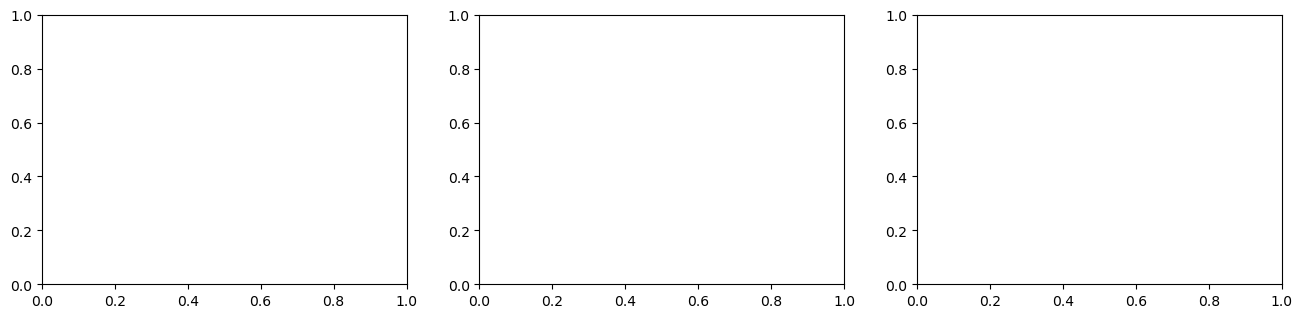

In [ ]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches([16, 3.5])  # Adjusted figure size
dict_list = [
    trace_jacobian_bc_log_dic,
    trace_jacobian_ic_log_dic,
    trace_jacobian_res_log_dic,
]
lines = []  # List to collect Line2D objects for the legend
labels = []  # List to collect corresponding labels

for index in range(len(dict_list)):
    data_list = [
        # {
        #     "data": dict_list[index]["bspline"],
        #     "color": model_color["bspline"],
        #     "name": "B-spline",
        #     "alpha": 1.0,
        # },
        {
            "data": dict_list[index]["tanh"],
            "color": model_color["tanh"],
            "name": "Tanh",
            "alpha": 1.0,
        },
        # {
        #     "data": dict_list[index]["grbf"],
        #     "color": model_color["grbf"],
        #     "name": "GRBF",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["fourier"],
        #     "color": model_color["fourier"],
        #     "name": "Fourier",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["param_tanh"],
        #     "color": model_color["param_tanh"],
        #     "name": "parametric-Tanh",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["chebyshev"],
        #     "color": model_color["chebyshev"],
        #     "name": "Chebyshev",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["jacobi"],
        #     "color": model_color["jacobi"],
        #     "name": "Jacobi",
        #     "alpha": 1.0,
        # },
    ]

    plot_spectral(ax[index], data_list)

for line in ax[-1].get_lines():
    lines.append(line)
    labels.append(line.get_label())

save_path = os.path.join(logger.get_output_dir(), "spectral_cavity.png")

legend = fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=7
)
legend.get_frame().set_facecolor("white")

plt.tight_layout()
plt.savefig(save_path)